<a href="https://colab.research.google.com/drive/1cbpxgL8h7H_GXsQidOmnLD6yaOn0OMty?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нейросетевая классификация текстов


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 39.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


### импорт необходимых библиотек

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import pandas as pd
import random
import os

import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set(palette='summer')
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import re
import time
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Данные (загрузка)

[Russian Social Media Text Classification](https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification/data)


Датасет содержит тексты из спортивных сообществ социальной сети ВКонтакте.
Содержит 13 подкатегорий тем.

In [5]:
# https://github.com/lteplova/rnn_in_nlp/blob/main/data/dataset_media.zip

!wget https://github.com/lteplova/rnn_in_nlp/raw/0a8c6345a1250af3ef5439fbb054c7092c5e88cd/data/dataset_media.zip
# https://github.com/lteplova/dl26_ssd/raw/bcc33d74d825e5c790f5f43518ca96277f6c69b4/archive.zip

--2024-05-02 16:40:52--  https://github.com/lteplova/rnn_in_nlp/raw/0a8c6345a1250af3ef5439fbb054c7092c5e88cd/data/dataset_media.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lteplova/rnn_in_nlp/0a8c6345a1250af3ef5439fbb054c7092c5e88cd/data/dataset_media.zip [following]
--2024-05-02 16:40:52--  https://raw.githubusercontent.com/lteplova/rnn_in_nlp/0a8c6345a1250af3ef5439fbb054c7092c5e88cd/data/dataset_media.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15816253 (15M) [application/zip]
Saving to: ‘dataset_media.zip’

dataset_media.zip   100%[===================>]  15.08M  --.-KB/s    in

In [6]:
!unzip dataset_media.zip

Archive:  dataset_media.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
#loading the data

reviews = pd.read_csv("train.csv")
print(reviews.shape)
reviews.head()

(38740, 3)


,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [9]:
set(reviews.category), len(set(reviews.category))

({'athletics',
  'autosport',
  'basketball',
  'boardgames',
  'esport',
  'extreme',
  'football',
  'hockey',
  'martial_arts',
  'motosport',
  'tennis',
  'volleyball',
  'winter_sport'},
 13)

In [10]:
reviews.text[1]

'Возвращение в подземелье Треша 33 Эйфория тупости и жадности зашкаливает 33 В этот раз мы посетим Ростовскую область. Всю. И знаете это пока что единственный выпуск в котором не будет. . . А впрочем сами все увидите 33 Ссылка на видео в источнике'

In [11]:
reviews[reviews.duplicated()] # вывод дубликатов

,oid,category,text
1482,842513089,basketball,Питание – один из самых важных процессов в наш...
1601,31593254,boardgames,Приветствуем коллеги 33 А во что вы играли на ...
2110,845723373,martial_arts,Это первое интервью Мокаева в Дагестане Молодо...
2130,240880977,martial_arts,Вам не нужно теперь ломать голову что подарить...
3561,885529499,martial_arts,Расписание на вторник КРАСНАЯ ПРЕСНЯ 19. 00 ММ...
...,...,...,...
38566,217746176,esport,Будет 2 победителя Принять участие Включить ув...
38607,774280988,hockey,Смотрите матч Спартак – Зенит на Кинопоиске. Д...
38651,550304346,basketball,За кроссовками в Баскетбольный магазин Ghetto ...
38668,229536361,basketball,За жилетами в Баскетбольный магазин Ghetto Bas...


In [12]:
# удаление дубликатов
reviews = reviews.drop_duplicates(keep=False)
reviews

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,776944963,volleyball,Стал известен календарь мужской сборной России...


In [13]:
# проверим распределение классов и сбалансированность датасета
# функция создает датасет с распределением классов
def loads_labels(dataset):
    labels = []
    for i in dataset:
        labels.append(i)
    counts = Counter(labels)
    count_df =  pd.DataFrame([(k, v) for k, v in counts.items()],
    columns=['category', 'count'])
    return count_df.sort_values(by = 'count', ascending = False)

In [14]:
df_balance = loads_labels(reviews.category.values)
df_balance.reset_index()

,index,category,count
0,10,autosport,3116
1,1,extreme,3020
2,7,motosport,3014
3,9,tennis,2996
4,11,martial_arts,2974
5,6,athletics,2947
6,4,hockey,2932
7,3,boardgames,2929
8,12,volleyball,2920
9,5,esport,2877


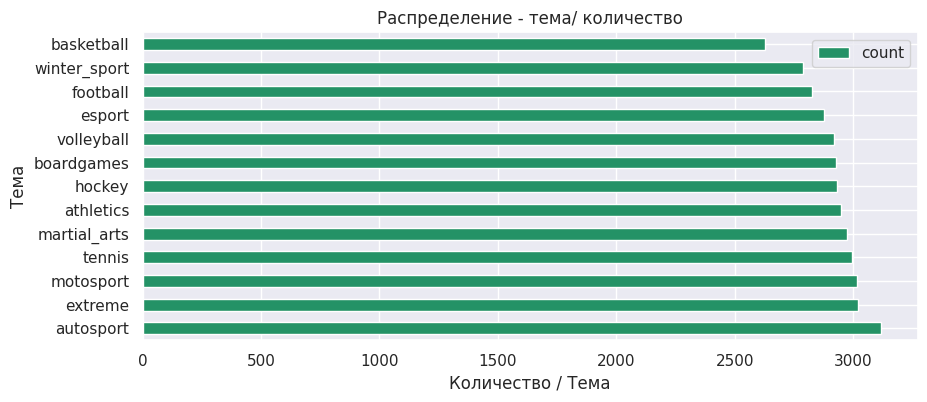

In [15]:
ax = df_balance.plot.barh(x='category', y='count', rot=0, figsize = (10,4), title='Распределение - тема/ количество',
                     xlabel='Количество / Тема',
                     ylabel='Тема')

Данные нормально сбалансированы по классам, можем использовать accuracy как метрику

In [16]:
# кодировка таргета
le = LabelEncoder()
le.fit(reviews['category'])
reviews['label'] =  le.transform(reviews['category'])
reviews

,oid,category,text,label
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,5
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,6
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,3
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,7
...,...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...,1
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...,1
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...,10
38738,776944963,volleyball,Стал известен календарь мужской сборной России...,11


In [17]:
# вычисление длин текстов
reviews['review_length'] = reviews['text'].apply(lambda x: len(x.split())) # length of post (words)
reviews

,oid,category,text,label,review_length
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12,6
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,5,43
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,6,110
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,3,209
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,7,382
...,...,...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...,1,61
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...,1,96
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...,10,43
38738,776944963,volleyball,Стал известен календарь мужской сборной России...,11,143


In [18]:
reviews.describe().T

,count,mean,std,min,25%,50%,75%,max
oid,37968.0,5.022693e+08,2.829830e+08,16594.0,266756352.0,506829589.0,741931849.0,999711263.0
label,37968.0,5.997340e+00,3.736898e+00,0.0,3.0,6.0,9.0,12.0
review_length,37968.0,6.136623e+01,7.188862e+01,3.0,16.0,35.0,75.0,634.0


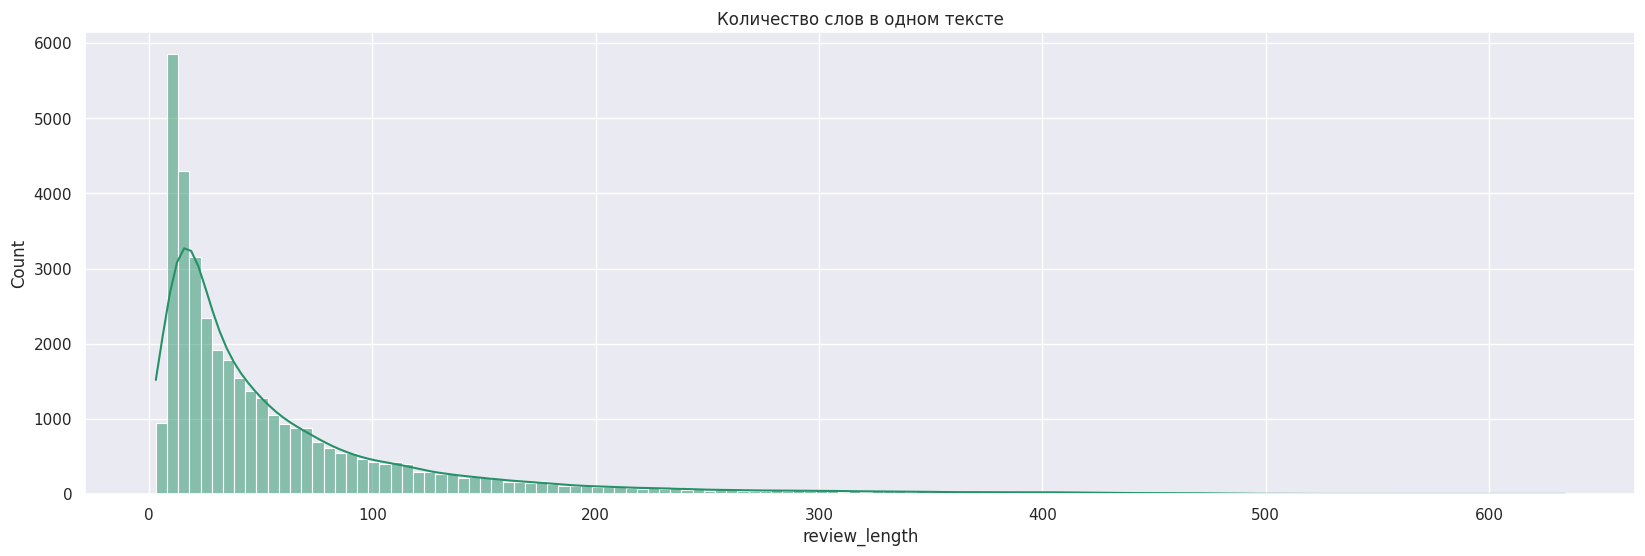

In [20]:
plt.figure(figsize = (20, 6))
sns.histplot(reviews["review_length"], kde=True, binwidth=5).set_title("Количество слов в одном тексте");

In [21]:
# подготовка датасета, сохранение нужных колонок
df = pd.DataFrame()
df['text'] = reviews.text.values
df['label'] = reviews.label.values
df

,text,label
0,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12
1,Возвращение в подземелье Треша 33 Эйфория тупо...,5
2,Лучшие чешские вратари – Доминик Доминатор Гаш...,6
3,Rtokenoid Warhammer40k валрак решил нас подкор...,3
4,Шестеркин затаскивает Рейнджерс в финал Восточ...,7
...,...,...
37963,8 битная буря снова накрыла пикселями автомоби...,1
37964,Ира Сидоркова объясняет как сказалась на ее ма...,1
37965,24 я ракетка мира хорват Марин Чилич обыграл и...,10
37966,Стал известен календарь мужской сборной России...,11


In [22]:
df.to_csv('trainn.csv', index=False)

In [24]:
# Создадим датасет, с которым будем работать дальше, для передачи в модель
dataset = load_dataset('csv', data_files='trainn.csv')
dataset = dataset.filter(lambda example: example['text'] is not None and example['label'] is not None)

dataset

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/37968 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 37968
    })
})

In [25]:
# разделим на обучающую и тестовую
dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 30374
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7594
    })
})

In [26]:
# вывод одного примера
dataset['train'][0]

{'text': 'Королева переобуваний перебежчицу Трусову публично подвергли порицанию. Влюбленная спортсменка снова забыла кто стоял за ее успехом. Пока русская ракета Саша Трусова оттачивает знаменитые четверные коллеги по льду строят спортсменке козни.',
 'label': 12}

### Токенизация

In [27]:
# токенизация текстов (разбиение текстов на токены (слова) с помощью word_tokenize)
words = Counter()
for example in tqdm(dataset['train']['text']):
  processed_text = example.lower()
  for word in word_tokenize(processed_text):
    words[word] += 1

  0%|          | 0/30374 [00:00<?, ?it/s]

In [ ]:
len(words)

133397

In [29]:
tags = ['<unk>', '<bos>','<eos>', '<pad>'] # служебные токены, для обозначение начала, конца текста и отсутствующих слов в словаре
vocab = set(tags)
counter_threshold = 5

# формирование словаря c учетом counter_threshold
for char, count in words.items():
  if count > counter_threshold:
    vocab.add(char)

len(vocab)

28633

In [30]:
# кодирование в словарь (слово-индекс) и обратно (индекс-слово)
word2idx = {char:i for i, char in enumerate(vocab)}
idx2word = {i:char for char, i in word2idx.items()}

In [31]:
# Создание  pytorch датасета

class WordDataset:
  def __init__(self, sent):
    self.data = sent
    self.unk_id, self.bos_id, self.eos_id, self.pad_id  = [word2idx[tag] for tag in tags]

  def __getitem__(self, idx: int) -> dict:
    processed_txt = self.data[idx]['text'].lower().translate(str.maketrans('', '', string.punctuation)) # препроцессинг
    tok_sent = [self.bos_id]
    tok_sent += [word2idx.get(word, self.unk_id) for word in word_tokenize(processed_txt)] # кодирование по словарю
    tok_sent += [self.eos_id]

    train_sample = {
        'text': tok_sent,
        'label': self.data[idx]['label']
    }
    return train_sample


  def __len__(self) -> int:
    return len(self.data)

# упаковка в тензоры одинаковой длины
def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2idx["<pad>"], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for seq in input_batch:
        seq['text'] = seq['text'][:max_seq_len]
        for _ in range(max_seq_len - len(seq['text'])):
            seq['text'].append(pad_id)

        new_batch.append(seq['text'])

    seqs = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)
    return {'input_idx': seqs, 'label': labels}

In [32]:
# фиксация стэйта
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(42)

In [35]:
train_dataset = WordDataset(dataset['train'])
eval_dataset = WordDataset(dataset['test'])
batch_size = 64

# формирование dataloader
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
next(iter(train_dataloader))

{'input_idx': tensor([[18791,  7618,   666,  ..., 24644, 24644, 24644],
         [18791,  2666, 16676,  ..., 24644, 24644, 24644],
         [18791, 11763,   633,  ..., 24644, 24644, 24644],
         ...,
         [18791,  5338, 28218,  ..., 24644, 24644, 24644],
         [18791, 12395, 25901,  ..., 24644, 24644, 24644],
         [18791,  8517, 13602,  ..., 24644, 24644, 24644]], device='cuda:0'),
 'label': tensor([ 2,  5,  0,  7,  0,  4,  7,  2,  8,  5, 10,  8, 12,  4,  6,  3,  9, 11,
          5,  1,  1,  8, 12,  8, 12,  5,  3, 12, 10, 10,  1,  6, 10, 11, 10, 10,
          9,  5, 12, 12,  6, 10,  7,  5,  8,  0,  3,  9, 11, 12,  9, 11,  7, 12,
          0,  7,  8,  6,  0, 11,  8, 10,  3,  1], device='cuda:0')}

In [37]:
for el in train_dataloader:
    print(el['input_idx'].shape)
    break

torch.Size([64, 256])


## Обучение модели

#### Функции обучение/отрисовка результата

In [38]:
# функция для валидации
def evaluate(model, eval_dataloader) -> float:
    """
    Вычисление accuracy на валидационной выборке
    """

    predictions = []
    target = []
    loss_ = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_idx'])
            loss = criterion(logits, batch['label'])
            loss_.append(loss.item())
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()
    loss_eval = sum(loss_) / len(loss_)

    return accuracy, loss_eval

In [41]:
# Функция запуска обучения
def train_loop_max(epoch):
    num_epoch = epoch
    eval_steps = len(train_dataloader) // 2

    history = defaultdict(lambda: defaultdict(list))
    loss_train, loss_eval, acc, = [], [], []
    best_model = None
    best_val_acc = 0.0

    for epoch in range(num_epoch):
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch+1}:')):

            logits = model(batch['input_idx'])
            loss = criterion(logits, batch['label'])
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i % eval_steps == 0:
                model.eval()
                accuracy, loss_ev = evaluate(model, eval_dataloader)
                loss_eval.append(loss_ev)
                acc.append(accuracy)
                model.train()


        lr_value = optimizer.state_dict()['param_groups'][0]['lr']
        history['lr']['step'].append(lr_value)
        scheduler.step()

        loss_tr = sum(loss_train) / len(loss_train)
        loss_ev = sum(loss_eval) / len(loss_eval)

        print('train_loss', loss_tr)
        print('val_loss', loss_ev)
        print(f'val_accuracy, {accuracy*100:.2f}')
        print('learning rate', lr_value)



        history['loss_t']['train'].append(loss_tr)
        history['loss_e']['train'].append(loss_ev)
        history['acc']['eval'].append(accuracy)

        if accuracy > best_val_acc:  # проверка метрики и сохранение лучшей модели на основании лучшей метрики
            best_val_acc = accuracy
            best_model = model.state_dict()

    model.load_state_dict(best_model)
    return model, history

In [42]:
def plot_learning(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    plt.figure(figsize=(20, 5))

    plt.subplot(1,3,1)
    plt.title('Loss', fontsize=10)
    plt.plot(history['loss_t']['train'], color='red', label='train')
    plt.plot(history['loss_e']['train'], color='blue', label='val')
    plt.ylabel('лосс', fontsize=10)
    plt.xlabel('эпоха', fontsize=10)
    plt.legend(fontsize=10)

    plt.subplot(1,3,2)
    plt.title('Accuracy', fontsize=8)
    plt.plot(history['acc']['eval'], label='validation')
    plt.ylabel('лосс', fontsize=10)
    plt.xlabel('эпоха', fontsize=10)
    plt.legend(fontsize=10)

    plt.subplot(1,3,3)
    plt.title("learning vs. epoch", fontsize=8)
    plt.plot(history['lr']['step'], color='orange', label='steps')
    plt.xlabel("эпоха", fontsize=8)
    plt.ylabel("learning rate", fontsize=8)
    plt.legend(fontsize=5)
    plt.show()

    print(f"Лучшая accuracy : {(max(history['acc']['eval']) * 100):.2f}")

#### Архитектура сети

Рекурентный слой LSTM, Bidirectional = True, используем максимум из слоя Embedding и конкатенируем с эмбедингом последнего слоя, функция активации nn.Tanh()

In [43]:
class RNN_Classiff_max(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int, num_layers: int,
        aggregation_type: str = 'max'
        ):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, bidirectional = True, dropout = 0.2, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 4, hidden_dim)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:

            embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
            output, h = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
            output_max = output.max(dim=1)[0] #[batch_size, hidden_dim] (берем агрегацию по максимуму)
            last_hidden_state = output[:, -1, :] # эмбеддинг с последнего токена
            output = torch.cat((last_hidden_state, output_max), dim=1) #  конкатенация результата агрегации и эмбеддинга с последнего токена

            concat_output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
            concat_output = self.batchnorm(concat_output)
            prediction = self.projection(self.non_lin(concat_output))  # [batch_size, num_classes]

            return prediction

#### Запуск обучения

In [44]:
model = RNN_Classiff_max(hidden_dim=256, vocab_size=len(vocab), num_classes = len(set(df.label)), num_layers = 2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 6, 8], gamma=0.7)

In [45]:
model, history = train_loop_max(epoch = 10)

Training epoch 1::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 1.5378626425642716
val_loss 1.5985373881350713
val_accuracy, 71.95
learning rate 0.001


Training epoch 2::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 1.1083440827382238
val_loss 1.2012880646965416
val_accuracy, 78.65
learning rate 0.001


Training epoch 3::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.8673033506985296
val_loss 1.045939160133499
val_accuracy, 79.77
learning rate 0.001


Training epoch 4::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.7031547368729585
val_loss 0.977372614703342
val_accuracy, 80.80
learning rate 0.001


Training epoch 5::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.5823416833034472
val_loss 0.9460020430198236
val_accuracy, 81.25
learning rate 0.0007


Training epoch 6::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.49483186908866883
val_loss 0.9322846469258059
val_accuracy, 81.14
learning rate 0.0007


Training epoch 7::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.43027303742636974
val_loss 0.9282878562420451
val_accuracy, 81.52
learning rate 0.00049


Training epoch 8::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.38118168243617556
val_loss 0.9283810693572381
val_accuracy, 81.68
learning rate 0.00049


Training epoch 9::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.34212847591595646
val_loss 0.9306141168500565
val_accuracy, 81.46
learning rate 0.000343


Training epoch 10::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.3108310461749911
val_loss 0.9352509064083337
val_accuracy, 80.92
learning rate 0.000343


#### Отображение результата

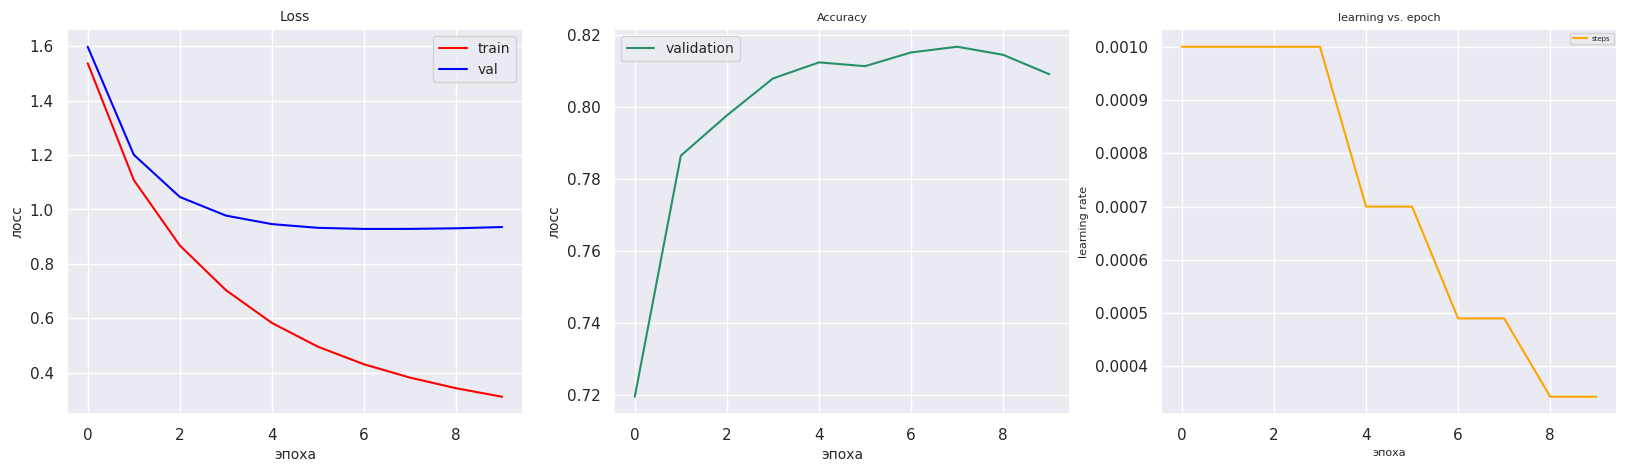

Лучшая accuracy : 81.68


In [46]:
plot_learning(history)

In [70]:
saved_model = torch.load('best.pt')
saved_model

RNN_Classiff_max(
  (embedding): Embedding(28633, 256)
  (rnn): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (linear): Linear(in_features=1024, out_features=256, bias=True)
  (batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (projection): Linear(in_features=256, out_features=13, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.3, inplace=False)
)

## Инференс

In [71]:
test = pd.read_csv("test.csv") # загрузка тестового датасета

In [72]:
test_text = test['text'][100]
test_text

'Встречаем вторую порцию оформленных карточек и помним навыки НЕ критуют hetokenoid eqtokenoid hetokenoid tokenoid'

In [73]:
def inference(model, input_text, max_len=256):

    processed_txt = input_text.lower().translate(str.maketrans('', '', string.punctuation)) # препроцессинг
    unk_id, bos_id, eos_id, pad_id  = [word2idx[tag] for tag in tags] # тэги
    tok_sent = [word2idx.get(word, unk_id) for word in word_tokenize(processed_txt)] # токенизация
    tok_sent.insert(0, bos_id)
    tok_sent.insert(-1, eos_id)

    max_seq_len = min(len(tok_sent), max_len)
    seq = tok_sent[:max_seq_len]
    for _ in range(max_len - len(tok_sent)):
                seq.append(pad_id)
    seqs = torch.LongTensor(seq)
    seqs = seqs.reshape(1, 256).to(device)

    model.eval()
    logits = model(seqs)
    predictions = logits.argmax(dim=1)
    label = le.inverse_transform([predictions.item()])[0]

    return input_text, label

In [74]:
# вывод результата
sample, category = inference(saved_model, test['text'][5])
print(sample, '\n')
print(category)

19 июня ABL разыграет 100 000 рублей и чемпионские перстни всех дивизионов В этот день мы соберемся все вместе во дворце спорта Динамо на Лавочкина чтобы определить а затем и поздравить чемпионов сезона 33 Вместе с вами мы создадим ассоциацию баскетболистов любителей чтобы развивать любительский баскетбол в России и СНГ. Богатый на эмоции день ждет не только финалистов но и самых важных людей этого сезона болельщиков. Вы сможете Посмотреть красивые финалы дивизионов от Late до Htokenoid Провести весело время на интерактивных площадках Из каждого матча мы постараемся сделать зрелищное шоу Сделаем вам кучу крутых снимков и в фотозоне и в зале и везде где сможем поймать вас в объектив Пополнить гардероб выиграть футболку с символикой ABL Выиграть баскетбольный мяч в интересных конкурсах И главное своим присутствием вы поможете команде за которую болеете выиграть 100 000₽ на оплату взносов следующего сезона. В розыгрыше может участвовать любая команда ABL. Проход бесплатный но нужно зареги

In [75]:
sample, category = inference(saved_model, test['text'][15])
print(sample, '\n')
print(category)

Сидни Кросби первая звезда дня в НХЛ Капитан Пингвинз оформил первый хет трик с 28 ноября 2018 года. Он также 35 й раз в карьере набрал четыре очка за игру и занимает 24 е место в истории НХЛ по этому показателю. Набрав 1356 е очко Кросби обошел Ги Лефлера 1353 и Брендана Шэнахэна 1524 выйдя на 27 е место в истории НХЛ по результативности. 

hockey
